In [1]:
import os
import time
import sys
from pathlib import Path
import torch
import numpy as np
import psdr_jit as psdr
import drjit
from drjit.cuda.ad import Int as IntD, Float as FloatD, Matrix4f as Matrix4fD, Array3f as Vector3fD, Array2f as Vector2fD
from drjit.cuda import Float as FloatC, Matrix4f as Matrix4fC, Array3f as Vector3fC
from drjit.cuda import PCG32 as PCG32C, UInt64 as UInt64C
from image_util import *
import matplotlib.pyplot as plt
from PIL import Image
from embedder import *
from torch import nn
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# drjit.set_flag(drjit.JitFlag.LoopRecord, False)
# drjit.set_flag(drjit.JitFlag.VCallRecord, False)


In [2]:
class MyDiffuseBSDF(psdr.BSDF):
    def __init__(self, albedo):
        psdr.BSDF.__init__(self)
        self.texture = psdr.Bitmap3fD(albedo)

    def anisotropic(self):
        return False

    def to_string(self):
        return "MyDiffuseBSDF[id=" + self.id + "]";

    def eval(self, its, wo, active):
        with drjit.suspend_grad():
            wo.z = drjit.mulsign(wo.z, its.wi.z);
            its.wi.z = drjit.abs(its.wi.z);
            cos_theta_i = psdr.Frame.cos_theta(its.wi)
            cos_theta_o = psdr.Frame.cos_theta(wo)
            active &= cos_theta_i > 0
            active &=  cos_theta_o > 0

        return self.texture.eval(its.uv) & active


In [3]:
class SimpleIntegrator():
    def __init__(self, spp, width, height):
        self.width = width
        self.height = height
        self.num_pixels = self.width*self.height
        self.spp = spp
        self.sampler = psdr.Sampler()
        if self.spp > 0:
            self.sampler.seed(drjit.arange(UInt64C, self.spp*self.num_pixels))

    def Li(self, scene, ray, valid=True):
        ray = psdr.Ray(ray.o, ray.d)
        its = scene.ray_intersectAD(ray, valid)
        print("virtual call")
        value = its.shape.bsdf().eval(its, its.wi, valid)
        print("Li")
        print(drjit.mean(drjit.mean(value)))
        value[drjit.isnan(value)] = 0.
        value[drjit.isinf(value)] = 0.
        return value

    def render(self, scene, sensor_id):
        result = self.render_spp(scene, sensor_id)
        return result

    def render_spp(self, scene, sensor_id):
        result = drjit.zeros(Vector3fD, self.num_pixels)
        if self.spp == 0:
            return result
        with drjit.suspend_grad():
            idx = drjit.arange(IntD, self.num_pixels)
            num_samples = self.num_pixels * self.spp
            idx = drjit.arange(IntD, num_samples)
            idx = idx // self.spp
            dx, dy = drjit.meshgrid(drjit.arange(FloatD, self.width), drjit.arange(FloatD, self.height))
            samples_base = drjit.gather(Vector2fD, Vector2fD(dx, dy), idx)
            samples = (samples_base + self.sampler.next_2d())/Vector2fD(self.width, self.height);
            ray = scene.sensor[sensor_id].sample_primary_ray(samples);
        with drjit.resume_grad():
            value = self.Li(scene, ray)
            drjit.scatter_reduce(drjit.ReduceOp.Add, result, value, idx)
            result /= self.spp
        return result

In [4]:
sc = psdr.Scene()

sc.opts.spp = 64
sc.opts.sppe = 0
sc.opts.sppse = 0 
sc.opts.width = 512 
sc.opts.height = 512 

sc.opts.log_level = 0



In [5]:
sensor = psdr.PerspectiveCamera(30, 0.000001, 10000000.)
to_world = Matrix4fD([[1.,0.,0.,0.],
                     [0.,0.,-1.,5.],
                     [0.,1.,0.,0.],
                     [0.,0.,0.,1.],])
sensor.to_world = to_world
sc.add_Sensor(sensor)

In [6]:
mybsdf = MyDiffuseBSDF("./data/texture/illya.exr")
sc.add_BSDF(mybsdf, "illya")
sc.add_Mesh("./data/uv_plane.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]]), "illya", None, True)
sc.configure()

In [7]:
integrator = SimpleIntegrator(sc.opts.spp, sc.opts.height, sc.opts.width)

virtual call
Li
[0.27093592286109924]


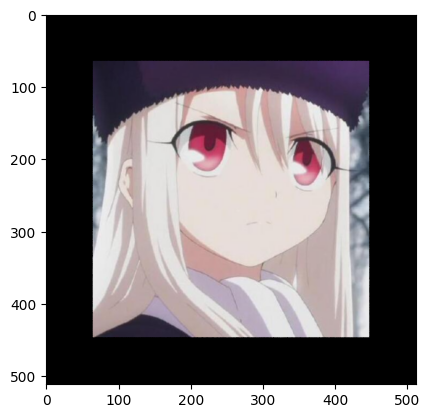

In [8]:
img_target = integrator.render(sc, 0)
img = img_target.numpy().reshape((sc.opts.width, sc.opts.height, 3))
img = to_srgb(np.asarray(img))
imgplot = plt.imshow(img)


In [9]:
class RenderFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, integrator, scene, sensor_id, param):
        with drjit.suspend_grad():
            scene.param_map["BSDF[0]"].texture.data = Vector3fD(param)
            drjit.eval(scene.param_map["BSDF[0]"].texture.data)
            psdr_image = integrator.render(scene, 0)
            image = psdr_image.torch()
            ctx.scene = scene
            ctx.integrator = integrator
            ctx.param = param
            return image.reshape((scene.opts.height, scene.opts.width, 3))

    @staticmethod
    def backward(ctx, grad_out):
        with drjit.resume_grad():
            drjit_param = ctx.scene.param_map["BSDF[0]"].texture.data
            drjit.enable_grad(drjit_param)
            image_grad = Vector3fC(grad_out.reshape(-1,3))
            image = ctx.integrator.render(ctx.scene, 0)
            tmp = drjit.dot(image_grad, image)
            drjit.backward(tmp)
            grad_tmp = drjit.grad(drjit_param)
            print("grad")
            print(drjit.mean(drjit.mean(drjit_param)), drjit.mean(drjit.mean(drjit.abs(grad_tmp))))
            drjit.disable_grad(drjit_param)
            param_grad = torch.nan_to_num(grad_tmp.torch().cuda())
            return tuple([None]*3 + [param_grad])

class Renderer(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, integrator, scene, sensor_id, param):
        image = RenderFunction.apply(integrator,scene,sensor_id,param)
        return image

In [10]:
fembed, embed_dim = get_embedder(10, 2)
print("embed_dim", embed_dim)
layer_size = 64
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(embed_dim, layer_size),
          nn.ReLU(),
          nn.Linear(layer_size, layer_size),
          nn.ReLU(),
          nn.Linear(layer_size, layer_size),
          nn.ReLU(),
          nn.Linear(layer_size, 3),
          nn.Sigmoid()
        ).cuda()
    def forward(self, x):
        return self.layers(x)

embed_dim 42


In [11]:
mlp_image = MLP()

In [12]:
x = np.linspace(0, 1, 512)
y = np.linspace(0, 1, 512)
debug_color = torch.tensor(np.meshgrid(x, y), dtype=torch.float32).cuda()
debug_color = (torch.transpose(debug_color.reshape(2, -1), 0, 1))
data_in = fembed(debug_color)
opt_map = mlp_image(data_in)



C:\Users\kai.yan\AppData\Local\Temp\ipykernel_21100\1001190937.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  debug_color = torch.tensor(np.meshgrid(x, y), dtype=torch.float32).cuda()


In [13]:
psdr_render = Renderer()
target_img = img_target.torch().reshape((sc.opts.width, sc.opts.height, 3))


virtual call
Li
[0.28267979621887207]
virtual call
Li
[0.28267568349838257]
grad
[0.5073872804641724] [6.879678267068812e-07]
it: 0 loss 0.12733103334903717


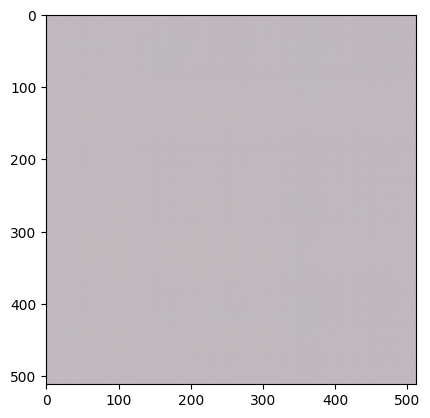

virtual call
Li
[0.2832040786743164]
virtual call
Li
[0.2825864553451538]
grad
[0.5072208642959595] [6.87287524669955e-07]
virtual call
Li
[0.28245386481285095]
virtual call
Li
[0.2824541926383972]
grad
[0.5069775581359863] [6.877082228129439e-07]
virtual call
Li
[0.28226354718208313]
virtual call
Li
[0.2822609543800354]
grad
[0.5066390633583069] [6.879680540805566e-07]
virtual call
Li
[0.28201258182525635]
virtual call
Li
[0.282016783952713]
grad
[0.5061933398246765] [6.883227570142481e-07]
virtual call
Li
[0.28170210123062134]
virtual call
Li
[0.2817080020904541]
grad
[0.5056271553039551] [6.885978791615344e-07]
virtual call
Li
[0.28131288290023804]
virtual call
Li
[0.28130626678466797]
grad
[0.5049290657043457] [6.887796075716324e-07]
virtual call
Li
[0.28085118532180786]
virtual call
Li
[0.2808460593223572]
grad
[0.5040950775146484] [6.888003554195166e-07]
virtual call
Li
[0.28031063079833984]
virtual call
Li
[0.28031131625175476]
grad
[0.5031304359436035] [6.888890311529394e-07]
v

grad
[0.48402002453804016] [6.759329380656709e-07]
virtual call
Li
[0.2709788382053375]
virtual call
Li
[0.27097785472869873]
grad
[0.48585596680641174] [6.756297921128862e-07]
virtual call
Li
[0.27161532640457153]
virtual call
Li
[0.27161839604377747]
grad
[0.4870041012763977] [6.754742116754642e-07]
virtual call
Li
[0.2711956799030304]
virtual call
Li
[0.2711940109729767]
grad
[0.4862402081489563] [6.752783292540698e-07]
virtual call
Li
[0.2701152563095093]
virtual call
Li
[0.2701106667518616]
grad
[0.4842990040779114] [6.750938155164476e-07]
virtual call
Li
[0.26946181058883667]
virtual call
Li
[0.2694593071937561]
grad
[0.4831150770187378] [6.748529699507344e-07]
virtual call
Li
[0.2698477804660797]
virtual call
Li
[0.2698511481285095]
grad
[0.4838121831417084] [6.7477185439202e-07]
virtual call
Li
[0.27079880237579346]
virtual call
Li
[0.27080267667770386]
grad
[0.48550984263420105] [6.747060297129792e-07]
virtual call
Li
[0.27131789922714233]
virtual call
Li
[0.27131909132003784]

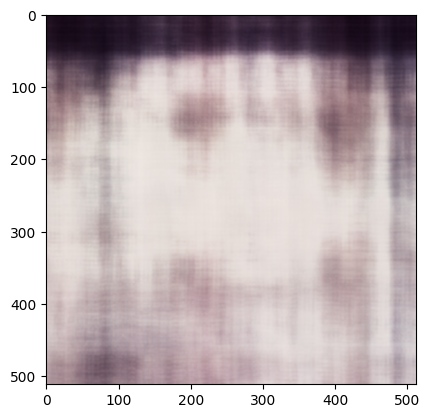

virtual call
Li
[0.27281975746154785]
virtual call
Li
[0.2728181481361389]
grad
[0.4890897274017334] [6.706466137984535e-07]
virtual call
Li
[0.272551953792572]
virtual call
Li
[0.2725529670715332]
grad
[0.48861053586006165] [6.704800625811913e-07]
virtual call
Li
[0.27262082695961]
virtual call
Li
[0.27261659502983093]
grad
[0.48873114585876465] [6.70338067720877e-07]
virtual call
Li
[0.27295976877212524]
virtual call
Li
[0.27296507358551025]
grad
[0.48934853076934814] [6.700662424918846e-07]
virtual call
Li
[0.27276211977005005]
virtual call
Li
[0.2727671265602112]
grad
[0.4889853596687317] [6.70025656290818e-07]
virtual call
Li
[0.2726554274559021]
virtual call
Li
[0.2726571261882782]
grad
[0.48879289627075195] [6.698270453853183e-07]
virtual call
Li
[0.27304285764694214]
virtual call
Li
[0.2730422616004944]
grad
[0.4894903898239136] [6.696582204313017e-07]
virtual call
Li
[0.2727894186973572]
virtual call
Li
[0.2727900743484497]
grad
[0.4890305995941162] [6.694020839859149e-07]
vir

grad
[0.4887941777706146] [6.595354875571502e-07]
virtual call
Li
[0.2684597074985504]
virtual call
Li
[0.2684605121612549]
grad
[0.48117196559906006] [6.594266324100317e-07]
virtual call
Li
[0.2748924791812897]
virtual call
Li
[0.27489277720451355]
grad
[0.49270951747894287] [6.598083359676821e-07]
virtual call
Li
[0.2678127884864807]
virtual call
Li
[0.26781103014945984]
grad
[0.48001593351364136] [6.593225521100976e-07]
virtual call
Li
[0.2738465666770935]
virtual call
Li
[0.27384650707244873]
grad
[0.490835964679718] [6.591183705495496e-07]
virtual call
Li
[0.27024000883102417]
virtual call
Li
[0.2702382802963257]
grad
[0.48436814546585083] [6.587266625501798e-07]
virtual call
Li
[0.27081018686294556]
virtual call
Li
[0.27080926299095154]
grad
[0.4853869378566742] [6.585366918443469e-07]
virtual call
Li
[0.2732170820236206]
virtual call
Li
[0.27322107553482056]
grad
[0.48970848321914673] [6.586649874407158e-07]
virtual call
Li
[0.2684345841407776]
virtual call
Li
[0.268434405326843

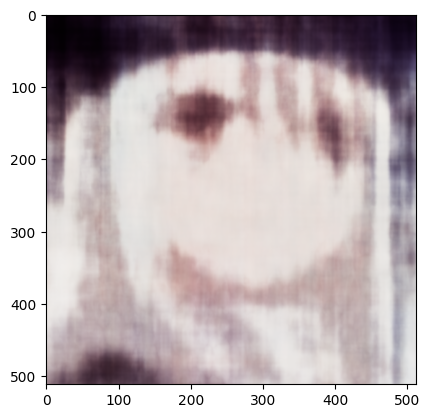

virtual call
Li
[0.26836827397346497]
virtual call
Li
[0.26836729049682617]
grad
[0.48099982738494873] [6.550687885464868e-07]
virtual call
Li
[0.2731529474258423]
virtual call
Li
[0.2731565535068512]
grad
[0.4895872473716736] [6.549171303049661e-07]
virtual call
Li
[0.27026814222335815]
virtual call
Li
[0.2702665328979492]
grad
[0.4844056963920593] [6.544870529978652e-07]
virtual call
Li
[0.27111852169036865]
virtual call
Li
[0.27112114429473877]
grad
[0.48593175411224365] [6.543377821799368e-07]
virtual call
Li
[0.2721341848373413]
virtual call
Li
[0.27212977409362793]
grad
[0.48774999380111694] [6.543709787365515e-07]
virtual call
Li
[0.2694292366504669]
virtual call
Li
[0.2694346010684967]
grad
[0.48290717601776123] [6.541971515616751e-07]
virtual call
Li
[0.2738291919231415]
virtual call
Li
[0.27382954955101013]
grad
[0.49079498648643494] [6.545441806338204e-07]
virtual call
Li
[0.26768168807029724]
virtual call
Li
[0.2676863670349121]
grad
[0.47977128624916077] [6.546746931235248

grad
[0.4895336329936981] [6.479025955741236e-07]
virtual call
Li
[0.2681039571762085]
virtual call
Li
[0.2681036591529846]
grad
[0.4804776608943939] [6.484090135927545e-07]
virtual call
Li
[0.2748323380947113]
virtual call
Li
[0.2748347818851471]
grad
[0.49254703521728516] [6.49363187221752e-07]
virtual call
Li
[0.2671223282814026]
virtual call
Li
[0.26711779832839966]
grad
[0.47871363162994385] [6.490905661848956e-07]
virtual call
Li
[0.27459007501602173]
virtual call
Li
[0.2745897173881531]
grad
[0.49210816621780396] [6.49103867544909e-07]
virtual call
Li
[0.2684187889099121]
virtual call
Li
[0.2684209942817688]
grad
[0.48103708028793335] [6.478451837210741e-07]
virtual call
Li
[0.27258777618408203]
virtual call
Li
[0.272580623626709]
grad
[0.48850518465042114] [6.473946996266022e-07]
virtual call
Li
[0.2706446945667267]
virtual call
Li
[0.2706446051597595]
grad
[0.48503392934799194] [6.468291076089372e-07]
virtual call
Li
[0.2704465687274933]
virtual call
Li
[0.2704503536224365]
gr

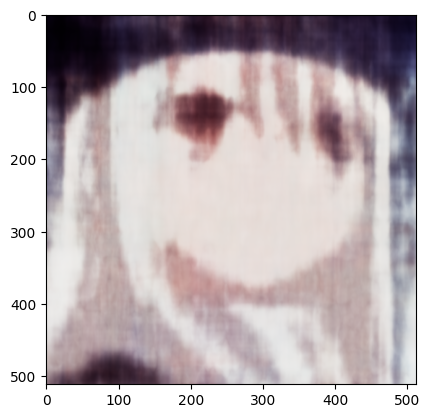

virtual call
Li
[0.27392637729644775]
virtual call
Li
[0.27392467856407166]
grad
[0.4908961057662964] [6.463984618676477e-07]
virtual call
Li
[0.26929813623428345]
virtual call
Li
[0.2693014144897461]
grad
[0.4826018214225769] [6.452117986555095e-07]
virtual call
Li
[0.2718207538127899]
virtual call
Li
[0.27181947231292725]
grad
[0.4871189296245575] [6.449724878621055e-07]
virtual call
Li
[0.27134400606155396]
virtual call
Li
[0.2713450789451599]
grad
[0.4862669110298157] [6.448674412240507e-07]
virtual call
Li
[0.2700319290161133]
virtual call
Li
[0.270029753446579]
grad
[0.48391324281692505] [6.447722853408777e-07]
virtual call
Li
[0.2730023264884949]
virtual call
Li
[0.2730056047439575]
grad
[0.48924118280410767] [6.453301466535777e-07]
virtual call
Li
[0.2685137391090393]
virtual call
Li
[0.268517404794693]
grad
[0.4811904728412628] [6.453378773585428e-07]
virtual call
Li
[0.2745361924171448]
virtual call
Li
[0.2745363414287567]
grad
[0.491987943649292] [6.463862405325926e-07]
virt

virtual call
Li
[0.26790764927864075]
virtual call
Li
[0.2679116129875183]
grad
[0.4800981283187866] [6.424397724913433e-07]
virtual call
Li
[0.275382399559021]
virtual call
Li
[0.2753859758377075]
grad
[0.4935021996498108] [6.429528980333998e-07]
virtual call
Li
[0.26718568801879883]
virtual call
Li
[0.2671818733215332]
grad
[0.47879666090011597] [6.431311021515285e-07]
virtual call
Li
[0.2750585079193115]
virtual call
Li
[0.2750532329082489]
grad
[0.49291443824768066] [6.424694447559887e-07]
virtual call
Li
[0.2685251533985138]
virtual call
Li
[0.2685287594795227]
grad
[0.4812008738517761] [6.416156566046993e-07]
virtual call
Li
[0.2731161117553711]
virtual call
Li
[0.2731119990348816]
grad
[0.4894295334815979] [6.404050054698018e-07]
virtual call
Li
[0.2706124484539032]
virtual call
Li
[0.2706148624420166]
grad
[0.48494845628738403] [6.399234848686319e-07]
virtual call
Li
[0.2711203098297119]
virtual call
Li
[0.2711179852485657]
grad
[0.485848605632782] [6.398098548743292e-07]
virtu

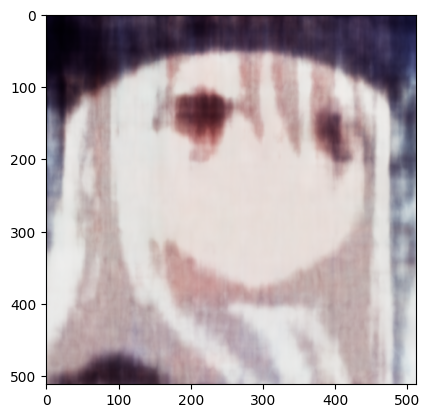

virtual call
Li
[0.27269110083580017]
virtual call
Li
[0.27269378304481506]
grad
[0.48866769671440125] [6.387539883689897e-07]
virtual call
Li
[0.2692677974700928]
virtual call
Li
[0.26926693320274353]
grad
[0.48252561688423157] [6.394875526893884e-07]
virtual call
Li
[0.2743924856185913]
virtual call
Li
[0.2743939161300659]
grad
[0.4917221963405609] [6.401753012141853e-07]
virtual call
Li
[0.26747554540634155]
virtual call
Li
[0.26747798919677734]
grad
[0.47931012511253357] [6.414718995984003e-07]
virtual call
Li
[0.27578264474868774]
virtual call
Li
[0.27578526735305786]
grad
[0.49421024322509766] [6.418611633307592e-07]
virtual call
Li
[0.26712483167648315]
virtual call
Li
[0.2671305537223816]
grad
[0.4786863327026367] [6.415085636035656e-07]
virtual call
Li
[0.2747165560722351]
virtual call
Li
[0.2747059464454651]
grad
[0.4922832250595093] [6.404550845218182e-07]
virtual call
Li
[0.26906970143318176]
virtual call
Li
[0.269059956073761]
grad
[0.4821653962135315] [6.393286184902536e-

virtual call
Li
[0.26834341883659363]
grad
[0.480851411819458] [6.374686449817091e-07]
virtual call
Li
[0.27533435821533203]
virtual call
Li
[0.2753290832042694]
grad
[0.49339061975479126] [6.388150382008462e-07]
virtual call
Li
[0.266904354095459]
virtual call
Li
[0.26690685749053955]
grad
[0.47828447818756104] [6.394894853656297e-07]
virtual call
Li
[0.27576321363449097]
virtual call
Li
[0.27576181292533875]
grad
[0.4941660761833191] [6.39450149719778e-07]
virtual call
Li
[0.26777219772338867]
virtual call
Li
[0.26776623725891113]
grad
[0.47982919216156006] [6.378708121701493e-07]
virtual call
Li
[0.2738431692123413]
virtual call
Li
[0.27384519577026367]
grad
[0.4907306730747223] [6.36851211766043e-07]
virtual call
Li
[0.2699308395385742]
virtual call
Li
[0.26993438601493835]
grad
[0.48371222615242004] [6.355046480166493e-07]
virtual call
Li
[0.271903395652771]
virtual call
Li
[0.27190709114074707]
grad
[0.48724761605262756] [6.352754553518025e-07]
virtual call
Li
[0.2717422246932983

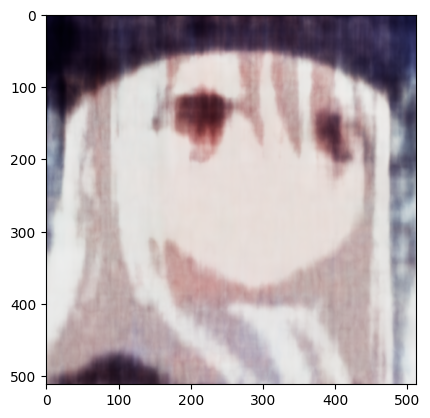

virtual call
Li
[0.27142930030822754]
virtual call
Li
[0.2714272141456604]
grad
[0.4863896071910858] [6.341181801872153e-07]
virtual call
Li
[0.27206018567085266]
virtual call
Li
[0.2720617949962616]
grad
[0.48751863837242126] [6.341746257021441e-07]
virtual call
Li
[0.27016013860702515]
virtual call
Li
[0.2701667547225952]
grad
[0.4841175973415375] [6.343373684103426e-07]
virtual call
Li
[0.2733769714832306]
virtual call
Li
[0.2733752131462097]
grad
[0.4898797869682312] [6.350189210024837e-07]
virtual call
Li
[0.26861295104026794]
virtual call
Li
[0.26861071586608887]
grad
[0.48133695125579834] [6.358137625284144e-07]
virtual call
Li
[0.27510952949523926]
virtual call
Li
[0.27510881423950195]
grad
[0.49297985434532166] [6.370898404384207e-07]
virtual call
Li
[0.26710373163223267]
virtual call
Li
[0.26711031794548035]
grad
[0.47863608598709106] [6.381347930073389e-07]
virtual call
Li
[0.2758391499519348]
virtual call
Li
[0.27583327889442444]
grad
[0.4942868947982788] [6.382763899637212

grad
[0.4938254654407501] [6.358195605571382e-07]
virtual call
Li
[0.26703667640686035]
virtual call
Li
[0.267034649848938]
grad
[0.47850263118743896] [6.365065701174899e-07]
virtual call
Li
[0.2754627764225006]
virtual call
Li
[0.2754570245742798]
grad
[0.4936100244522095] [6.354807737807278e-07]
virtual call
Li
[0.2682574689388275]
virtual call
Li
[0.2682601809501648]
grad
[0.4806946814060211] [6.342628466882161e-07]
virtual call
Li
[0.2736337184906006]
virtual call
Li
[0.2736310064792633]
grad
[0.490331768989563] [6.329222514978028e-07]
virtual call
Li
[0.27022552490234375]
virtual call
Li
[0.27022892236709595]
grad
[0.48422253131866455] [6.32024125479802e-07]
virtual call
Li
[0.2718560993671417]
virtual call
Li
[0.271852970123291]
grad
[0.4871438145637512] [6.315707423709682e-07]
virtual call
Li
[0.27176326513290405]
virtual call
Li
[0.27176156640052795]
grad
[0.48697903752326965] [6.314951406238833e-07]
virtual call
Li
[0.2704361379146576]
virtual call
Li
[0.2704407572746277]
grad

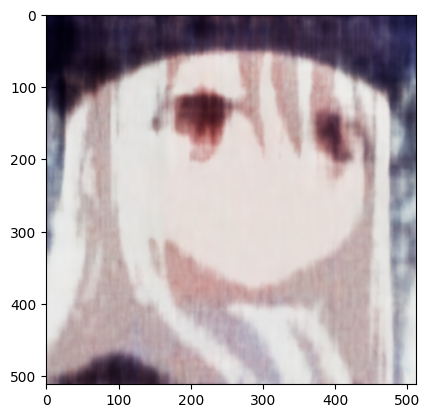

virtual call
Li
[0.2688988447189331]
virtual call
Li
[0.2688986659049988]
grad
[0.48183324933052063] [6.324105470412178e-07]
virtual call
Li
[0.27492183446884155]
virtual call
Li
[0.27492526173591614]
grad
[0.4926401674747467] [6.337465947581222e-07]
virtual call
Li
[0.2672866880893707]
virtual call
Li
[0.2672922909259796]
grad
[0.47895824909210205] [6.352410082399729e-07]
virtual call
Li
[0.2758334279060364]
virtual call
Li
[0.2758229970932007]
grad
[0.49426794052124023] [6.351426691253437e-07]
virtual call
Li
[0.2675391733646393]
virtual call
Li
[0.26753997802734375]
grad
[0.47940555214881897] [6.347313501464669e-07]
virtual call
Li
[0.2744961380958557]
virtual call
Li
[0.27450031042099]
grad
[0.4918821454048157] [6.329571533569833e-07]
virtual call
Li
[0.2694549560546875]
virtual call
Li
[0.2694515585899353]
grad
[0.4828404188156128] [6.316535063888296e-07]
virtual call
Li
[0.27255135774612427]
virtual call
Li
[0.2725463807582855]
grad
[0.48838746547698975] [6.307617468337412e-07]
v

grad
[0.4869087338447571] [6.288191798375919e-07]
virtual call
Li
[0.2717769145965576]
virtual call
Li
[0.2717773914337158]
grad
[0.4869999587535858] [6.28650923317764e-07]
virtual call
Li
[0.2706892192363739]
virtual call
Li
[0.27068355679512024]
grad
[0.4850424528121948] [6.289489533628512e-07]
virtual call
Li
[0.272993803024292]
virtual call
Li
[0.2729972004890442]
grad
[0.48918575048446655] [6.292472676250327e-07]
virtual call
Li
[0.2692256271839142]
virtual call
Li
[0.26922574639320374]
grad
[0.4824241101741791] [6.302785777734243e-07]
virtual call
Li
[0.27475136518478394]
virtual call
Li
[0.27474918961524963]
grad
[0.49233007431030273] [6.317214911177871e-07]
virtual call
Li
[0.2672763466835022]
virtual call
Li
[0.2672746181488037]
grad
[0.47892817854881287] [6.336024966913101e-07]
virtual call
Li
[0.27609947323799133]
virtual call
Li
[0.27610188722610474]
grad
[0.4947577714920044] [6.340469553833827e-07]
virtual call
Li
[0.2672783136367798]
virtual call
Li
[0.2672763168811798]
g

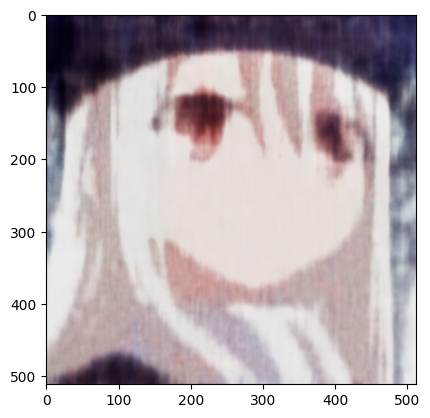

virtual call
Li
[0.26950177550315857]
virtual call
Li
[0.2694993019104004]
grad
[0.48292094469070435] [6.292248144745827e-07]
virtual call
Li
[0.274482399225235]
virtual call
Li
[0.2744910418987274]
grad
[0.4918596148490906] [6.307242301772931e-07]
virtual call
Li
[0.2674342393875122]
virtual call
Li
[0.2674344778060913]
grad
[0.47921180725097656] [6.328763788587821e-07]
virtual call
Li
[0.27622348070144653]
virtual call
Li
[0.2762286067008972]
grad
[0.4949786067008972] [6.337302238534903e-07]
virtual call
Li
[0.2670406103134155]
virtual call
Li
[0.2670382857322693]
grad
[0.478506863117218] [6.334921636153013e-07]
virtual call
Li
[0.27505674958229065]
virtual call
Li
[0.27504801750183105]
grad
[0.4928799867630005] [6.314357960945927e-07]
virtual call
Li
[0.269092857837677]
virtual call
Li
[0.26909202337265015]
grad
[0.48218870162963867] [6.297553341028106e-07]
virtual call
Li
[0.2730386555194855]
virtual call
Li
[0.27303749322891235]
grad
[0.48926693201065063] [6.28511656941555e-07]
vi

virtual call
Li
[0.2720942795276642]
virtual call
Li
[0.2720955014228821]
grad
[0.4875769019126892] [6.26752353127813e-07]
virtual call
Li
[0.2714998126029968]
virtual call
Li
[0.27150678634643555]
grad
[0.4865082800388336] [6.267671324167168e-07]
virtual call
Li
[0.27103763818740845]
virtual call
Li
[0.2710381746292114]
grad
[0.4856807589530945] [6.265770480240462e-07]
virtual call
Li
[0.2725370526313782]
virtual call
Li
[0.27253568172454834]
grad
[0.48836350440979004] [6.268061838454742e-07]
virtual call
Li
[0.26983803510665894]
virtual call
Li
[0.26983359456062317]
grad
[0.48352307081222534] [6.275039936554094e-07]
virtual call
Li
[0.27413344383239746]
virtual call
Li
[0.27413463592529297]
grad
[0.4912300705909729] [6.286553571044351e-07]
virtual call
Li
[0.2678658366203308]
virtual call
Li
[0.26786479353904724]
grad
[0.47998711466789246] [6.305805868578318e-07]
virtual call
Li
[0.27608537673950195]
virtual call
Li
[0.27608951926231384]
grad
[0.4947289824485779] [6.322120498225559e-

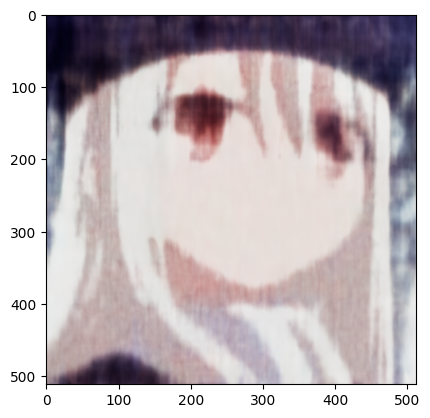

virtual call
Li
[0.2674768269062042]
virtual call
Li
[0.2674785852432251]
grad
[0.4792954623699188] [6.307877242761606e-07]
virtual call
Li
[0.27467241883277893]
virtual call
Li
[0.2746706008911133]
grad
[0.4921864867210388] [6.289369025580527e-07]
virtual call
Li
[0.269493967294693]
virtual call
Li
[0.26949888467788696]
grad
[0.4829190969467163] [6.272397286011255e-07]
virtual call
Li
[0.27269798517227173]
virtual call
Li
[0.2727002203464508]
grad
[0.488656222820282] [6.26395433300786e-07]
virtual call
Li
[0.2711092531681061]
virtual call
Li
[0.27110522985458374]
grad
[0.4858093559741974] [6.260906957322732e-07]
virtual call
Li
[0.27128276228904724]
virtual call
Li
[0.27128303050994873]
grad
[0.4861198663711548] [6.259701308408694e-07]
virtual call
Li
[0.27236005663871765]
virtual call
Li
[0.2723603844642639]
grad
[0.48805171251296997] [6.261680027819239e-07]
virtual call
Li
[0.27000582218170166]
virtual call
Li
[0.2700028121471405]
grad
[0.48382437229156494] [6.266189416237467e-07]
v

virtual call
Li
[0.2677447199821472]
grad
[0.4797687232494354] [6.293963679127046e-07]
virtual call
Li
[0.27588194608688354]
virtual call
Li
[0.27588504552841187]
grad
[0.4943670928478241] [6.303274631136446e-07]
virtual call
Li
[0.26738524436950684]
virtual call
Li
[0.26738816499710083]
grad
[0.4791280925273895] [6.299124493125419e-07]
virtual call
Li
[0.27509433031082153]
virtual call
Li
[0.27509641647338867]
grad
[0.49295711517333984] [6.283171387622133e-07]
virtual call
Li
[0.2689821720123291]
virtual call
Li
[0.26898783445358276]
grad
[0.48199743032455444] [6.267807748372434e-07]
virtual call
Li
[0.27320432662963867]
virtual call
Li
[0.2732004225254059]
grad
[0.48955798149108887] [6.256719871089444e-07]
virtual call
Li
[0.2706892192363739]
virtual call
Li
[0.270694375038147]
grad
[0.4850616455078125] [6.250135129448608e-07]
virtual call
Li
[0.2716875672340393]
virtual call
Li
[0.27168604731559753]
grad
[0.48684415221214294] [6.246245902730152e-07]
virtual call
Li
[0.27194750308990

In [ ]:
optimizer = torch.optim.Adam(mlp_image.parameters(), lr=1e-3)
num_iter = 10000
for it in range(num_iter+1):
    optimizer.zero_grad()

    opt_map = mlp_image(data_in)#.reshape((512, 512, 3))
    
#     loss = (target_img.reshape((-1, 3))-opt_map).abs().mean()

    curr_img = psdr_render(integrator, sc, 0, opt_map)
    
#     psdr_image = integrator.render(sc, 0)
#     break
    loss = (target_img-curr_img).abs().mean()

    loss.backward()

    optimizer.step()

    if it % 100 == 0:
        print("it:", it, "loss", loss.item())
#         img = to_srgb(curr_img.detach().cpu().numpy().reshape((sc.opts.width, sc.opts.height, 3)))
        img = to_srgb(opt_map.detach().cpu().numpy().reshape((sc.opts.width, sc.opts.height, 3)))
        imgplot = plt.imshow(img)
        plt.show()
#     torch.cuda.empty_cache()
# #     drjit.registry_clear()
#     drjit.sync_thread()
#     drjit.sync_device()
#     drjit.eval()
    
